In [30]:
!pip install torchsummary

In [31]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from textwrap import wrap
from PIL import Image
from tqdm import tqdm
import spacy

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import torch.nn.functional as F
from torchvision import utils
from torchvision.io import read_image
import torchvision.models as models
import torchvision.transforms as T
from torchsummary import summary

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

Using cuda device


# Set Data and Model constants

In [33]:
data_dir = '/kaggle/input/flickr8k'

In [34]:
image_folder = os.path.join(data_dir, 'Images')
captions_file = os.path.join(data_dir, 'captions.txt')

# Visualize Data

In [35]:
captions_df = pd.read_csv(captions_file)
print("There are {} captions".format(len(captions_df)))
captions_df.head(5)

There are 40455 captions


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [36]:
def readImage(path,img_size=224):
    img = Image.open(path)
    img = img.resize((img_size,img_size))
    img = np.asarray(img)
    return img


def display_images(df):
    samples_df = df.sample(16)
    samples_df = samples_df.reset_index(drop=True)

    fig = plt.figure(figsize=(20.,20.))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(4, 4),
                     axes_pad=1.)
    
    for ax, i in zip(grid, range(20)):
        image = readImage(os.path.join(image_folder, samples_df.image[i]))
        ax.set_title("\n".join(wrap(samples_df.caption[i], 40)), fontdict=None, loc='center', color = "k")
        ax.imshow(image)

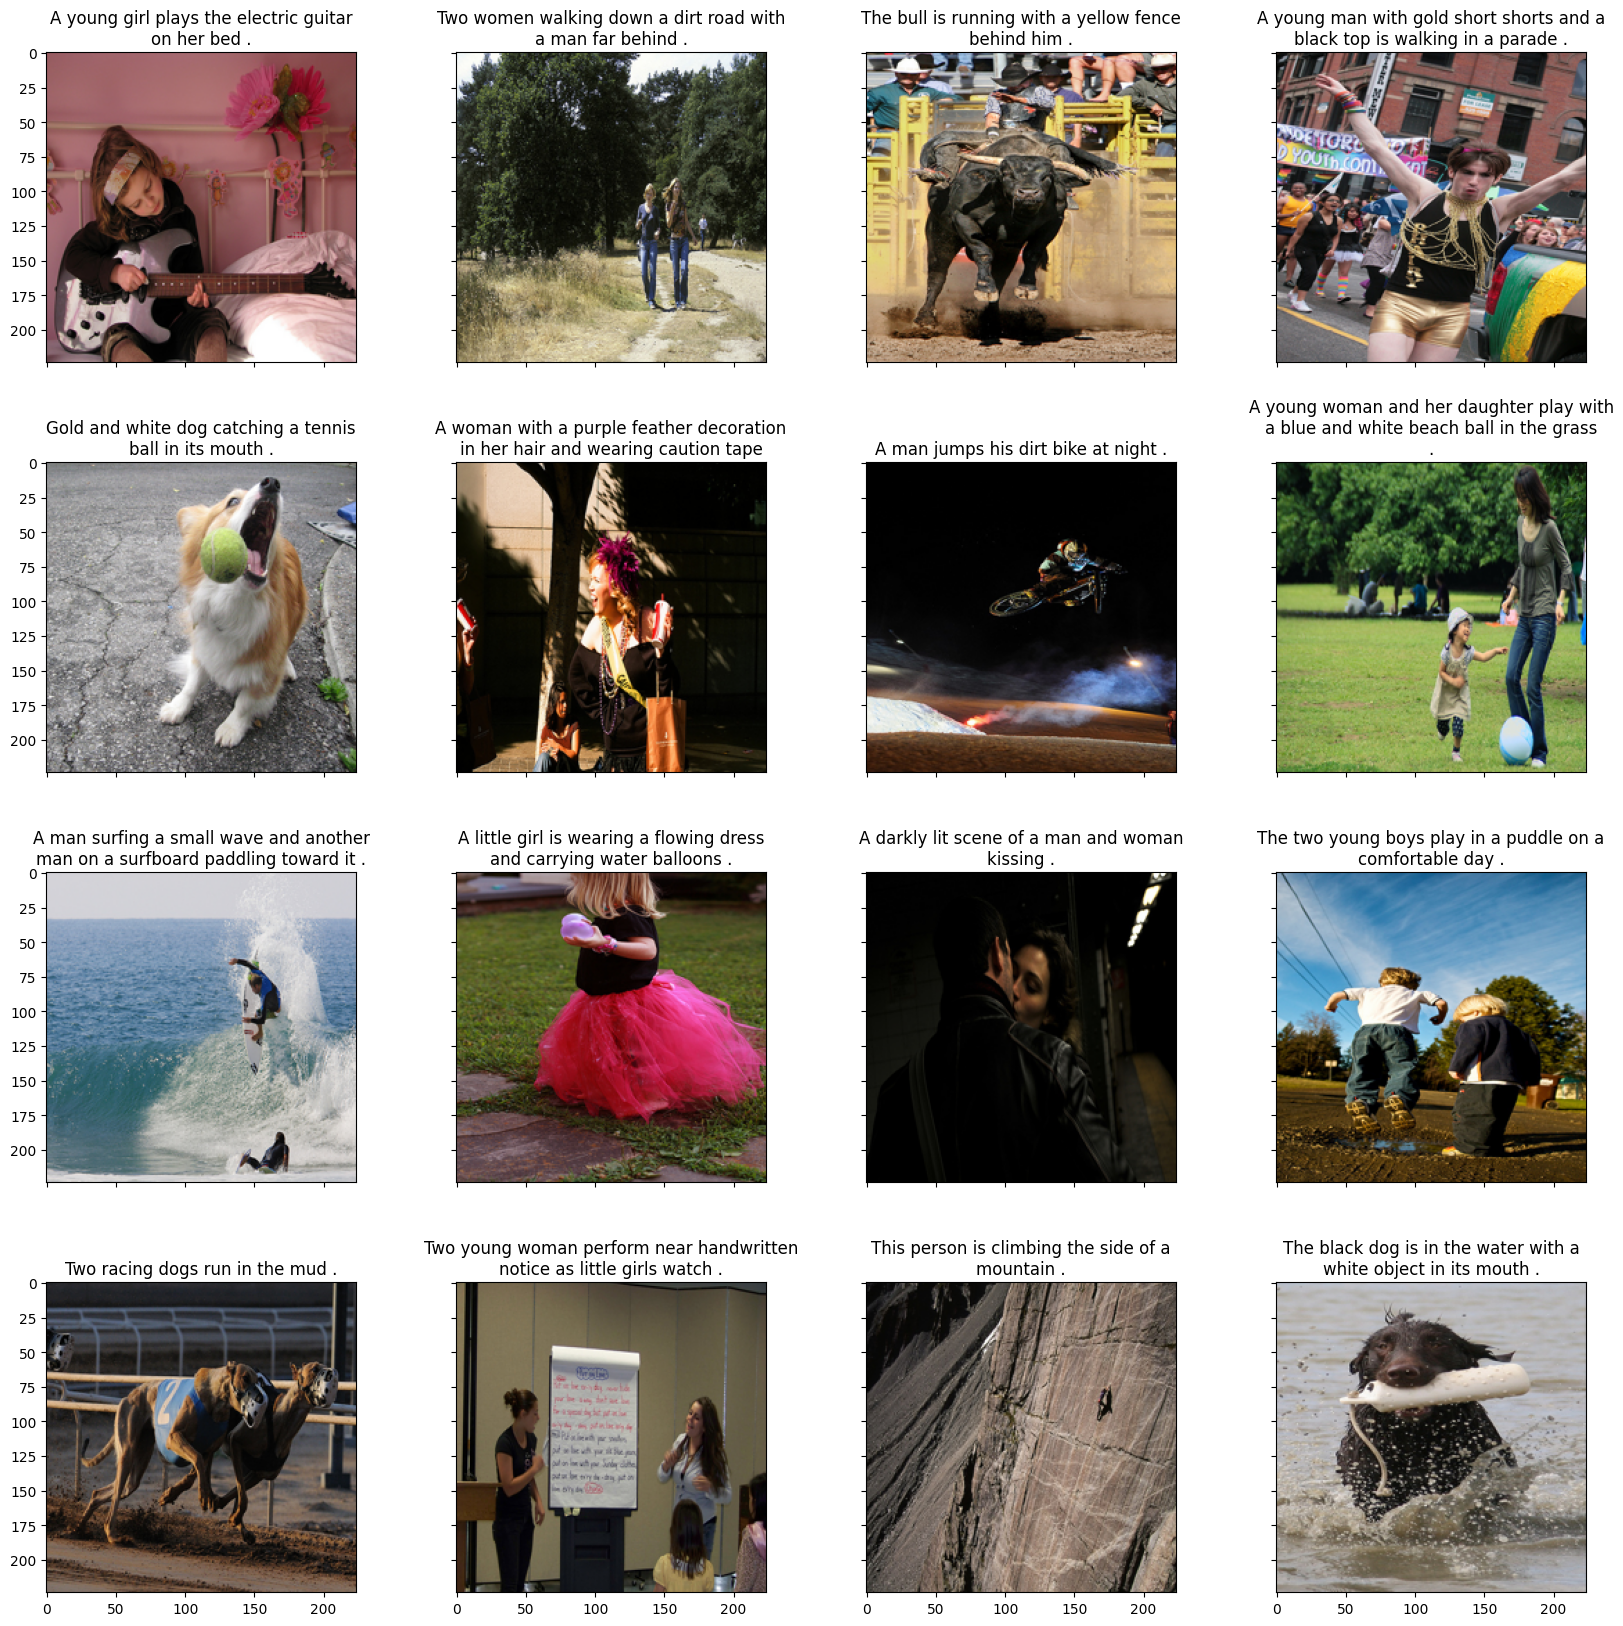

In [37]:
display_images(captions_df)

# Data Processing

In [38]:
spacy_eng = spacy.load("en_core_web_sm")

In [39]:
class Vocabulary:
    def __init__(self, freq_threshold=1):
        self.itos = {0:"<PAD>",1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold
    
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenize(caption):
        return [token.text.lower() for token in spacy_eng.tokenizer(caption)]
    
    def build_vocabulary(self, caption_list):
        frequencies = {}
        idx = self.__len__()
        
        for caption in caption_list:
            for word in self.tokenize(caption):
                frequencies[word] = frequencies.get(word, 0) + 1
                
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
                    
    def numericalize(self, caption):
        tokenized_caption = self.tokenize(caption)
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_caption
        ]

In [40]:
v = Vocabulary(freq_threshold=1)

v.build_vocabulary(["This is a good place to find a city"])
print(v.stoi)
print(v.numericalize("This is a good place to find a city here!!"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'good': 7, 'place': 8, 'to': 9, 'find': 10, 'city': 11}
[4, 5, 6, 7, 8, 9, 10, 6, 11, 3, 3, 3]


In [41]:
class FlickrDataset(Dataset):
    def __init__(self, imgs_dir, df, vocab, transform=None, freq_threshold=1):
        self.imgs_dir = imgs_dir
        self.df = df
        self.vocab = vocab
        self.transform = transform
        
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.imgs_dir, img_id)).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
            
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return img, torch.tensor(numericalized_caption)

In [42]:
transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

In [43]:
# Build Vocabulary
freq_threshold = 1 
captions = captions_df["caption"]
vocab = Vocabulary(freq_threshold)
vocab.build_vocabulary(captions.tolist())

In [44]:
def split_images(df, split_ratio):
    images = df['image'].unique().tolist()
    nimages = len(images)

    split_index = round(split_ratio*nimages)
    images1 = images[:split_index]
    images2 = images[split_index:]

    df1 = df[df['image'].isin(images1)]
    df2 = df[df['image'].isin(images2)]
    
    assert (len(set(df1['image']) - set(df2['image']))) == (len(set(df1['image'])))
    
    df1.reset_index(inplace=True,drop=True)
    df2.reset_index(inplace=True,drop=True)
    
    return df1, df2

In [45]:
train_df, test_df = split_images(captions_df, 0.8)
train_df, val_df = split_images(train_df, 0.8)

In [46]:
train_dataset = FlickrDataset(image_folder, train_df, vocab, transform=transform)
val_dataset = FlickrDataset(image_folder, val_df, vocab, transform=transform)
test_dataset = FlickrDataset(image_folder, test_df, vocab, transform=transform)

In [47]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)

        return imgs, targets

In [48]:
BATCH_SIZE = 32
NUM_WORKERS = 1
SHUFFLE= True
PIN_MEMORY= True

pad_idx = train_dataset.vocab.stoi["<PAD>"]

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=SHUFFLE,
    pin_memory=PIN_MEMORY,
    collate_fn=MyCollate(pad_idx=pad_idx),
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=SHUFFLE,
    pin_memory=PIN_MEMORY,
    collate_fn=MyCollate(pad_idx=pad_idx),
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=SHUFFLE,
    pin_memory=PIN_MEMORY,
    collate_fn=MyCollate(pad_idx=pad_idx),
)

In [49]:
def display_dl_images(data_loader, dataset):
    fig = plt.figure(figsize=(20.,20.))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(4, 4),
                     axes_pad=1.)
    
    dataiter = iter(data_loader)
    batch = next(dataiter)
    images, captions = batch
    
    for ax, i in zip(grid, range(20)):
        img, cap = images[i], captions[i]
        caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
        eos_index = caption_label.index('<EOS>')
        caption_label = caption_label[1:eos_index]
        caption_label = ' '.join(caption_label)                      
        img = img.numpy().transpose((1, 2, 0))
        ax.set_title("\n".join(wrap(caption_label, 40)), fontdict=None, loc='center', color = "k")
        ax.imshow(img)

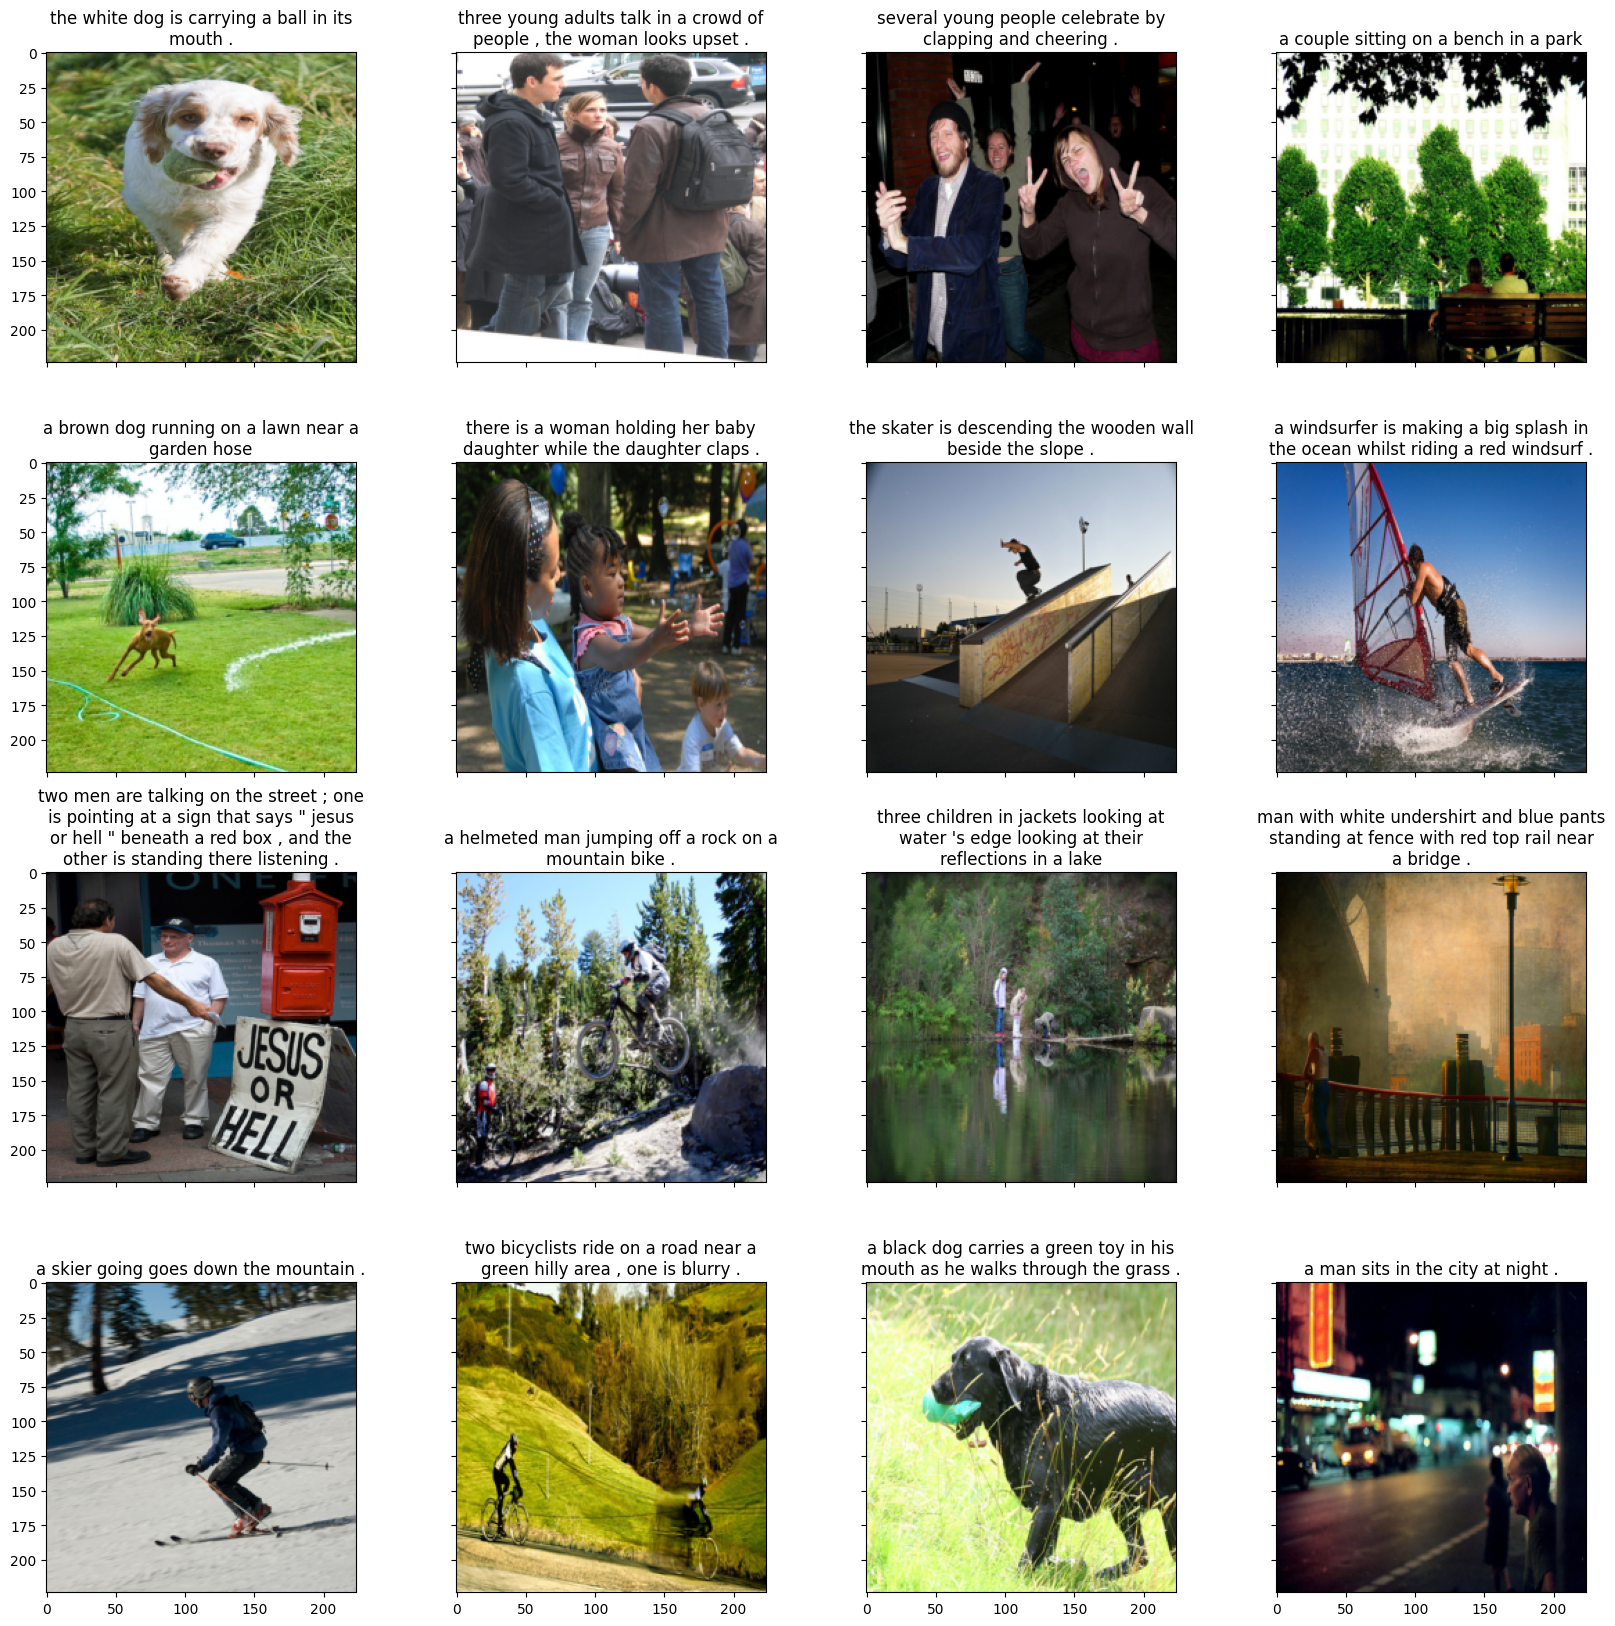

In [50]:
display_dl_images(train_loader, train_dataset)

# Model

In [51]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)          
        features = features.permute(0, 2, 3, 1)                          
        features = features.view(features.size(0), -1, features.size(-1))
        return features

In [52]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim) 
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  

    def forward(self, features, decoder_hidden):
        att1 = self.encoder_att(features) 
        att2 = self.decoder_att(decoder_hidden) 
        
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2) 

        
        alpha = self.softmax(att) 
        attention_weights = (features * alpha.unsqueeze(2)).sum(dim=1) 
        
        return alpha, attention_weights

In [53]:
class DecoderRNN(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, encoder_dim, vocab_size, dropout=0.5):
        super(DecoderRNN, self).__init__()
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.encoder_dim = encoder_dim
        self.vocab_size = vocab_size
        self.dropout = nn.Dropout(p=dropout)
        
        self.embedding = nn.Embedding(vocab_size, embed_dim) 
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim) 
        
        self.lstm_cell = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.f_beta = nn.Linear(decoder_dim, encoder_dim) 
        self.fc = nn.Linear(decoder_dim, vocab_size)  
        
    def forward(self, features, captions):
        embed = self.embedding(captions)
        h, c = self.init_hidden(features)
        
        seq_len = len(captions[0])-1 
        batch_size, feature_size = features.size(0), features.size(1)
        
        outputs = torch.zeros(batch_size, seq_len, self.vocab_size).to(device)
        atten_weights = torch.zeros(batch_size, seq_len, feature_size).to(device)
        
        for s in range(seq_len):
            alpha, attn_weights = self.attention(features, h)
            lstm_input = torch.cat((embed[:, s], attn_weights), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fc(self.dropout(h))
            outputs[:,s] = output
            atten_weights[:,s] = alpha  
        
        return outputs, atten_weights

    def init_hidden(self, features):
        mean_features = features.mean(dim=1)
        h = self.init_h(mean_features)
        c = self.init_c(mean_features)
        return h, c

In [54]:
class EncoderDecoder(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, encoder_dim, vocab_size, dropout=0.5):
        super(EncoderDecoder, self).__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            attention_dim=attention_dim,
            embed_dim=embed_dim,
            decoder_dim=decoder_dim,
            encoder_dim=encoder_dim,
            vocab_size=vocab_size,
            dropout=dropout
        )
    
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs
    
    def generate_caption(self, image, vocab, max_len=20):
        features = self.encoder(image)
        batch_size = features.size(0)
        h, c = self.decoder.init_hidden(features) 
        
        alphas = []
        result_caption = []

        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.decoder.embedding(word)
        
        for _ in range(max_len):
            alpha, context = self.decoder.attention(features, h)
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.decoder.lstm_cell(lstm_input, (h, c))
            output = self.decoder.fc(self.decoder.dropout(h))
            output = output.view(batch_size,-1)
            
            predicted_word_idx = output.argmax(dim=1)
            result_caption.append(predicted_word_idx.item())
            
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            embeds = self.decoder.embedding(predicted_word_idx.unsqueeze(0))
        
        return [vocab.itos[idx] for idx in result_caption], alphas

# Training

In [55]:
batch_size = 64       
embed_size = 256    
attention_size = 256
hidden_size = 512        
num_features = 2048  
vocab_size = len(vocab)
num_epochs = 5        
save_every = 1          
print_every = 100       
learning_rate = 3e-4

In [56]:
model = EncoderDecoder(
    attention_dim=attention_size,
    embed_dim=embed_size,
    decoder_dim=hidden_size,
    encoder_dim=num_features,
    vocab_size=vocab_size
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [57]:
# helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state.pth')

In [58]:
model.train()
for epoch in range(1, num_epochs+1):
    losses = []
    with tqdm(train_loader, unit="batch") as tepoch:
        for images, captions in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            images, captions = images.to(device), captions.to(device)

            outputs, attentions = model(images, captions)

            targets = captions[:,1:]
            loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            tepoch.set_postfix(loss=loss.item())
     
    print(f'Epoch {epoch} Training - Loss: {torch.tensor(losses).mean().item()}')
        
    losses = []
    with torch.no_grad():
        with tqdm(val_loader, unit="batch") as tepoch:
            for images, captions in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                images, captions = images.to(device), captions.to(device)

                outputs, attentions = model(images, captions)
                
#                 caption, alphas = model.generate_caption(images[0:1],vocab=vocab)
#                 caption = [word for word in caption if word not in ('<SOS>', ',', '.', '<EOS>')]
#                 caption = ' '.join(caption)
#                 print(caption)
                
                targets = captions[:,1:]
                loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

                losses.append(loss.item())
                tepoch.set_postfix(loss=loss.item())
            
            print(f'Epoch {epoch} Validation - Loss: {torch.tensor(losses).mean().item()}')

Epoch 1: 100%|██████████| 810/810 [02:36<00:00,  5.16batch/s, loss=3.75]


Epoch 1 Training - Loss: 4.177411079406738


Epoch 1: 100%|██████████| 203/203 [00:39<00:00,  5.16batch/s, loss=4.06]


Epoch 1 Validation - Loss: 3.7670693397521973


Epoch 2: 100%|██████████| 810/810 [02:36<00:00,  5.19batch/s, loss=2.32]


Epoch 2 Training - Loss: 3.434032917022705


Epoch 2: 100%|██████████| 203/203 [00:38<00:00,  5.26batch/s, loss=3.47]


Epoch 2 Validation - Loss: 3.479231834411621


Epoch 3: 100%|██████████| 810/810 [02:37<00:00,  5.14batch/s, loss=2.23]


Epoch 3 Training - Loss: 3.1632699966430664


Epoch 3: 100%|██████████| 203/203 [00:38<00:00,  5.32batch/s, loss=3.28]


Epoch 3 Validation - Loss: 3.3420298099517822


Epoch 4: 100%|██████████| 810/810 [02:39<00:00,  5.09batch/s, loss=2.8] 


Epoch 4 Training - Loss: 2.9899210929870605


Epoch 4: 100%|██████████| 203/203 [00:38<00:00,  5.33batch/s, loss=3.03]


Epoch 4 Validation - Loss: 3.264801263809204


Epoch 5: 100%|██████████| 810/810 [02:36<00:00,  5.19batch/s, loss=3.41]


Epoch 5 Training - Loss: 2.854943037033081


Epoch 5: 100%|██████████| 203/203 [00:39<00:00,  5.19batch/s, loss=3.37]

Epoch 5 Validation - Loss: 3.214106559753418


# Inference

In [59]:
def predict_caption(model, image):
    model.eval()
    with torch.no_grad():
        caption, alphas = model.generate_caption(image.unsqueeze(0).to(device),vocab=vocab)
        caption = [word for word in caption if word not in ('<SOS>', ',', '.', '<EOS>')]
        caption = ' '.join(caption)
        return caption, alphas

In [60]:
def convert_ids_to_words(ids):
    caption = [vocab.itos[idx] for idx in ids.numpy()]
    caption = [word for word in caption if word not in ('<SOS>', ',', '.', '<EOS>', '<PAD>')]
    return ' '.join(caption)

TRUE: a person jumping off a dock into water
PRED: a man is jumping into the water


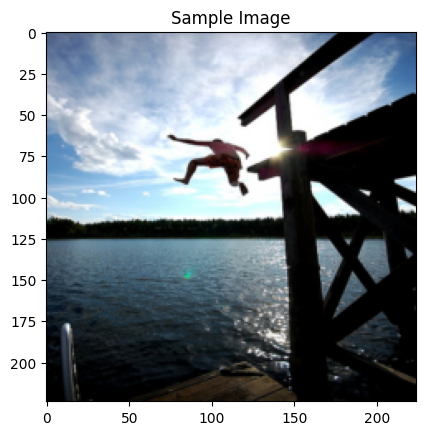

0.8340313804889192


In [73]:
from nltk.translate.bleu_score import sentence_bleu

images, caption = next(iter(test_loader))
img = images[0].detach().clone()
pred_caption, attns = predict_caption(model, img)
true_caption = convert_ids_to_words(caption[0])
print('TRUE:', true_caption)
print('PRED:', pred_caption)
plt.imshow(np.squeeze(img.numpy().transpose((1,2,0))))
plt.title('Sample Image')
plt.show()
bleu4 = sentence_bleu(true_caption, pred_caption)
print(bleu4)